In [1]:
# !pip install chart_studio
# !pip install pydot graphviz

In [2]:
!pip freeze > requirements.txt

In [11]:
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydot
import graphviz

import os
# # print(os.listdir("../input"))
# import chart_studio.plotly as py
# import chart_studio.graph_objs as go
import matplotlib.pyplot as plt

from sklearn.feature_extraction import stop_words
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys, tarfile
from sklearn.model_selection import train_test_split
import joblib

from IPython.display import Image

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dense, Activation, concatenate, Embedding, Flatten, Bidirectional, Concatenate, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [5]:
kindle_reviews = pd.read_csv('kindle_reviews.csv')

In [6]:
# Reformatting the dataframe display

pd.set_option('display.max_info_columns',1000)
pd.set_option('display.max_colwidth',5000)
kindle_reviews.drop(columns = ['asin', 'helpful', 'overall', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'],
                    axis=1, inplace=True)
kindle_reviews.columns = ['index','review', 'summary']
kindle_reviews.set_index(keys = 'index',inplace=True)

In [7]:
RNN_VOCAB = 10000                           # most frequent 15K words form the vocab 
MAX_SEQUENCE_REVIEW_LENGTH = 22             
MAX_SEQUENCE_SUMMARY_LENGTH = 9
EMBEDDING_DIM = 200                         
EMBEDDING_FILE_PATH = "glove.6B." + str(EMBEDDING_DIM) + "d.txt"

In [8]:
#  A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [9]:
def clean_text(text,remove_stopwords = True, max_len = 20):
    '''
    Given a text this function removes the punctuations, selected stopwords(because not, none convey some meaning and
    removing these stop words changes the meaning of the sentence.) and returns the length of the remaining text string
    '''
    refined_stop_words = {}
    if(remove_stopwords == True):
        refined_stop_words = stop_words.ENGLISH_STOP_WORDS-{ "not","none","nothing","nowhere","never",
                                                        "cannot","cant","couldnt","except","hasnt",
                                                        "neither","no","nobody","nor","without"
                                                           }
    try:
        #convert to lower case and strip regex
        new_text = []
        text = text.lower()
        count = 0
        for word in text.split():
            if word in refined_stop_words:
                continue
            count += 1
            if word in contractions: 
                new_text = new_text + [contractions[word]]
            else: 
                new_text = new_text + [word]
        new_text = new_text[0:max_len] if count>max_len else new_text
        text = ' '.join(new_text)
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        text = regex.sub(" ", text)
        text = re.sub('\s+', ' ', text).strip()
        text = '<start> ' + text + ' <end>'
        return text


    except:
        return ""

In [12]:
# kindle_reviews['summary'] = kindle_reviews.summary.apply(lambda x: clean_text(x, True, MAX_SEQUENCE_SUMMARY_LENGTH-2))
# kindle_reviews['review'] = kindle_reviews.review.apply(lambda x: clean_text(x, True, MAX_SEQUENCE_REVIEW_LENGTH-2))

# kindle_reviews.head()
filename='reveiws.save'
# joblib.dump(kindle_reviews, filename)

kindle_reviews = joblib.load(filename)

['reveiws.save']

In [13]:
kindle_reviews.shape

(982619, 2)

In [14]:
tokenize = Tokenizer(num_words = RNN_VOCAB, oov_token='OOV', filters = '')
tokenize.fit_on_texts(np.hstack([kindle_reviews['summary'],kindle_reviews['review']]))
kindle_reviews['sequence_summary'] = tokenize.texts_to_sequences(kindle_reviews['summary'])
kindle_reviews['sequence_review'] = tokenize.texts_to_sequences(kindle_reviews['review'])

In [15]:
#craeting dataset for the model input output
dataset = {}
dataset['decoder_input'] = pad_sequences(kindle_reviews.sequence_summary, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH, padding='post')
kindle_reviews['sequence_summary'] = kindle_reviews.sequence_summary.apply(lambda x: x[1:])
dataset['decoder_output'] = pad_sequences(kindle_reviews.sequence_summary, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH-1, padding='post')
dataset['encoder_input'] = pad_sequences(kindle_reviews.sequence_review, maxlen = MAX_SEQUENCE_REVIEW_LENGTH, padding='pre')


In [16]:
dataset['decoder_output'].shape, dataset['decoder_input'].shape, dataset['encoder_input'].shape

((982619, 8), (982619, 9), (982619, 22))

In [17]:
dataset['encoder_input'][0:2]

array([[   3,    2,   74, 6402,   20, 1739,   25,   21,    6,   66,  850,
           8,   46, 1533,  322, 5641, 1019,  526,  561,  180,    1,    4],
       [   0,    0,    3,    2,    6,    1,  134,   22, 1230,    1, 1758,
          45, 9612, 3958,  615,  154,   37, 1846,   22, 2243,    5,    4]],
      dtype=int32)

In [18]:
kindle_val_reviews = kindle_reviews.loc[1000:1005,:].copy()
gc.collect()


0

In [19]:
class Embeddings:
    """
    When a corpus is passed, remove the words which are not in the global vocab(glove) and use most frequent vocab_size
    number of words. 
    """
    def __init__(self, embedding_dim, vocab_size):
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
    def readEmbeddings(self, filePath):
        """
        Given a filepath of word embeddings creates and returns a dictionary of word, embedding values
        """
        # Create a dictionary for storing all {word, embedding values}
        wordToEmbeddingDict = {}
        # open the file as read only
        file = open(filePath, encoding='utf-8')
        # read all text
        for line in file:
            lineValue = line.split()
            word = lineValue[0]
            embedding = np.asarray(lineValue[1:],dtype = 'float32')
            wordToEmbeddingDict[word] = embedding
        # close the file
        file.close()
        return wordToEmbeddingDict
    
    def indexToEmbedding(self, wordToIndexDict, wordToEmbeddingDict):
        indexToEmbeddingMatrix = np.zeros((self.vocab_size, self.embedding_dim))
        for word, index in wordToIndexDict.items():
            if index >= self.vocab_size:
                break
            if word in wordToEmbeddingDict.keys():
                indexToEmbeddingMatrix[index] = wordToEmbeddingDict[word]
            else:
                indexToEmbeddingMatrix[index] = np.array(np.random.uniform(-1.0, 1.0, self.embedding_dim))

        return indexToEmbeddingMatrix
    
    def indexToWord(self, wordToIndexDict):
        return {index: word for word, index in wordToIndexDict.items()}

embeddings = Embeddings(EMBEDDING_DIM, RNN_VOCAB)
wordToEmbeddingDict = embeddings.readEmbeddings(EMBEDDING_FILE_PATH)

indexToEmbeddingMatrix = embeddings.indexToEmbedding(tokenize.word_index, wordToEmbeddingDict)



In [20]:
indexToWordDict = embeddings.indexToWord(tokenize.word_index)

In [21]:
BATCH_SIZE = 2096
NUM_EPOCHS = 3
STEPS_PER_EPOCH = 150
LATENT_DIM = 512                           # Dimensions of LSTM output



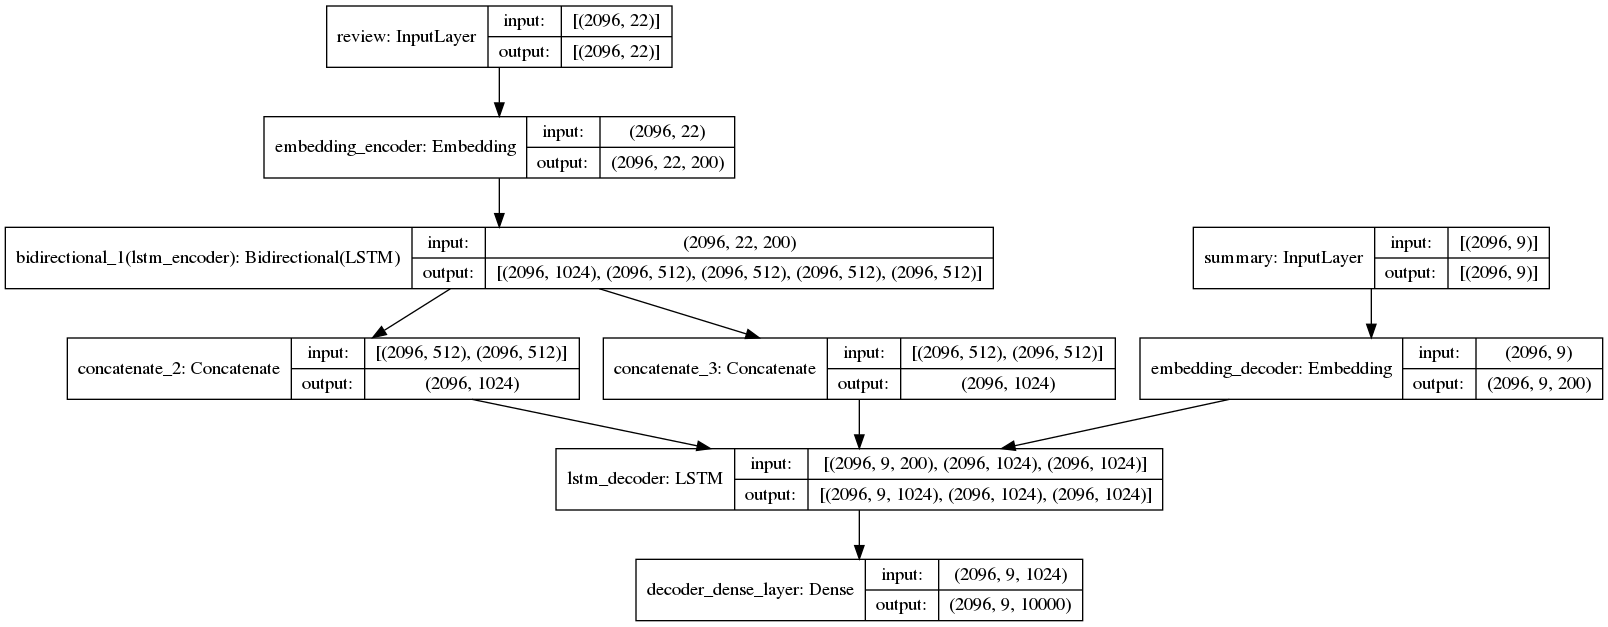

In [33]:


def get_batch_data(dataset, start, end):
    # Decoder output will be one hot encoded values 
    # dimensions of the decoder output will be (number of samples * summary length * vocab size)
    assert start < end
    assert end <= dataset['encoder_input'].shape[0]
    encoder_batch_input = dataset['encoder_input'][start:end]
    decoder_batch_input = dataset['decoder_input'][start:end]
    decoder_batch_output = np.zeros(((end-start), MAX_SEQUENCE_SUMMARY_LENGTH, RNN_VOCAB), dtype = 'float16')
    for k, row in enumerate(dataset['decoder_output'][start:end]):
        for i,value in enumerate(row):
            if value!=0:
                decoder_batch_output[k, i, value] = 1
    return encoder_batch_input, decoder_batch_input, decoder_batch_output

#This generate method loops indefinitely on our dataset to create training batches
def generate_batch_data(dataset):
    size = dataset['encoder_input'].shape[0]
    while True:
        start = 0
        end = start+BATCH_SIZE
        while True:
            # create numpy arrays of input data
            # and labels, from each line in the file
            if start>=size:
                break
            encoder_batch_input, encoder_batch_output, decoder_batch_output = get_batch_data(dataset, start, end)
            start = end
            end = np.min([end+BATCH_SIZE, size])
            yield ({'review': encoder_batch_input, 
                    'summary': encoder_batch_output},
                   {'decoder_dense_layer': decoder_batch_output})

review_input_layer = Input(batch_shape=(BATCH_SIZE, MAX_SEQUENCE_REVIEW_LENGTH, ), name = 'review')
embedding_encoder_layer = Embedding(input_length = MAX_SEQUENCE_REVIEW_LENGTH,
                          input_dim = RNN_VOCAB,
                          output_dim = EMBEDDING_DIM,
                          weights=[indexToEmbeddingMatrix],
                          trainable = False,
                          name = 'embedding_encoder',
                          )
embedding_review_output = embedding_encoder_layer(review_input_layer)
encoder_lstm_layer = Bidirectional(LSTM(LATENT_DIM, return_state=True, name = 'lstm_encoder', stateful = True), merge_mode = 'concat')
_, forward_h, forward_c, backward_h, backward_c = encoder_lstm_layer(embedding_review_output)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]


summary_input_layer = Input(batch_shape=(BATCH_SIZE ,MAX_SEQUENCE_SUMMARY_LENGTH, ), name = 'summary')
embedding_decoder_layer = Embedding(#input_length = MAX_SEQUENCE_SUMMARY_LENGTH,
                          input_dim = RNN_VOCAB,
                          output_dim = EMBEDDING_DIM,
                          weights=[indexToEmbeddingMatrix],
                          trainable=False,
                          name = 'embedding_decoder',
                          )
embedding_summary_output = embedding_decoder_layer(summary_input_layer)
decoder_lstm_layer = LSTM(2*LATENT_DIM, return_state=True, return_sequences = True, name = 'lstm_decoder', stateful = True)
decoder_output, decoder_h, decoder_c = decoder_lstm_layer(embedding_summary_output,
                                                   initial_state = encoder_states)

decoder_dense_layer = Dense(RNN_VOCAB, activation="softmax", name='decoder_dense_layer')
decoder_dense_output =  decoder_dense_layer(decoder_output)

model = Model([review_input_layer, summary_input_layer], decoder_dense_output) 
sgd = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

plot_model(model, to_file='model.png', show_shapes=True)


In [23]:
model.save_weights('summarization_weights.h5')

In [24]:
model.load_weights('summarization_weights.h5')

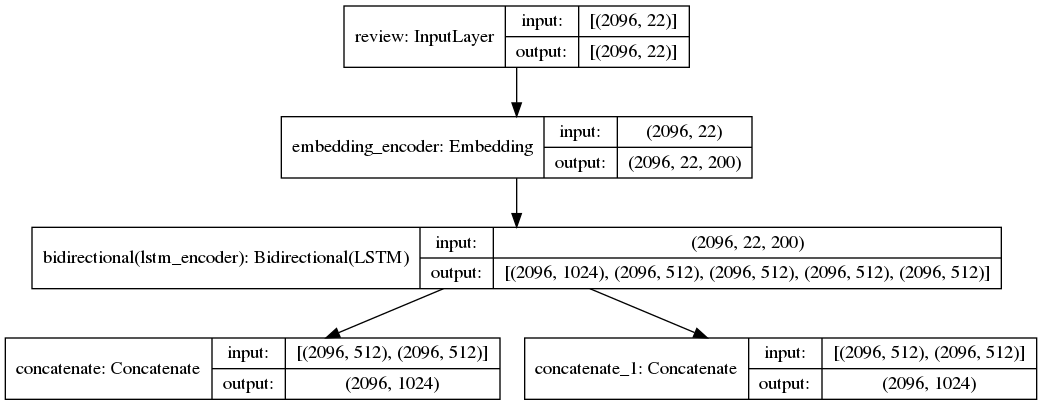

In [26]:
# Define inference model
encoder_inference_model = Model(review_input_layer, encoder_states)
plot_model(encoder_inference_model, to_file='inference_encoder.png', show_shapes=True)

# Image(filename='inference_encoder.png') 


In [28]:
decoder_state_input_h = Input(shape=(2*LATENT_DIM,))  # These states are required for feeding back to our next timestep decoder
decoder_state_input_c = Input(shape=(2*LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Now we shall reuse our decoder
summary_for_decoder = Input(shape=(1,))
embedding_summary_decoder = embedding_decoder_layer(summary_for_decoder)

decoder_inference_output, decoder_states_c, decoder_states_h = decoder_lstm_layer(embedding_summary_decoder, initial_state = decoder_states_inputs)
decoder_states_outputs = [decoder_states_c, decoder_states_h]
output_prob = decoder_dense_layer(decoder_inference_output)
decoder_inference_model = Model(
    [summary_for_decoder] + decoder_states_inputs,
    decoder_states_outputs + [output_prob])

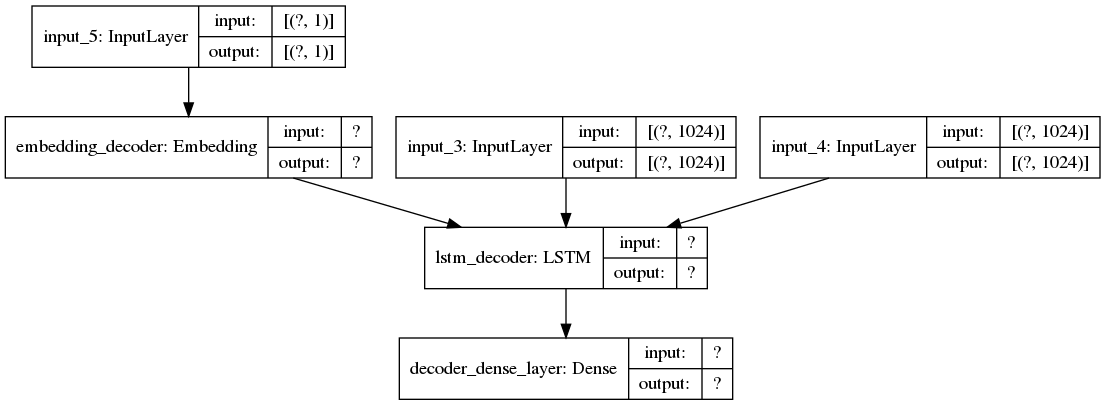

In [29]:
plot_model(decoder_inference_model, to_file='inference_decoder.png', show_shapes=True)

Image(filename='inference_decoder.png') 


In [30]:
def decode_sequence(input_sequence):
    # Encode the input as state vectors. states_h and states_c for decoder init
    encoder_states_value = encoder_inference_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1, for decoder input  
    # Populate the first character of target sequence with the start character.
    target_sequence = np.zeros((1,1))
    target_sequence[0,0] = tokenize.word_index['start']
    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = []
   
    while not stop_condition:
      
        h, c, output_tokens = decoder_inference_model.predict([target_sequence] + encoder_states_value,batch_size=1)
        # Sample a token
        
        sampled_word_index = np.argmax(output_tokens)#np.random.choice(np.arange(10003), p=output_tokens.flatten())
        if sampled_word_index == 0:
            decoded_sentence += ['<pad>']
            continue
        sampled_word = indexToWordDict[sampled_word_index]
        decoded_sentence += [sampled_word]
        
        # Exit condition: either hit max length=
        # or find stop character.
        if (sampled_word == 'end' or
           len(decoded_sentence) > MAX_SEQUENCE_SUMMARY_LENGTH):
            stop_condition = True


        # Update the target sequence (of length 1).
            target_sequence[0, 0] = sampled_word_index
        # Update states
        encoder_states_value = [h, c]
    return ' '.join(decoded_sentence)

In [34]:
def summarize(input_seq):
    input_seq = pad_sequences(tokenize.texts_to_sequences([clean_text(input_seq)]),MAX_SEQUENCE_REVIEW_LENGTH)
    return decode_sequence(input_seq)

In [35]:
summarize("The book was very nice, will read it again")

CancelledError:    [_Derived_]Loop execution was cancelled.
	 [[{{node while/LoopCond/_24}}]]
	 [[functional_5/bidirectional/backward_lstm_encoder/PartitionedCall]] [Op:__inference_predict_function_3155]

Function call stack:
predict_function -> predict_function -> predict_function
